In [1]:
# objective: generate the particle size structure for the CMIP6 models
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import glob,os,subprocess
import IPython.display as display
import math
from datetime import datetime as dt
%matplotlib inline

In [2]:
from scipy.stats import linregress

In [3]:
carbon_molar_mass = 12.011 # g/mol

## Pre step: read files, create lists for each group of files that we'll need.

In [4]:
# create pattern to load the files 
#model_list = [ 'cesm2', 'cmcc', 'cnrm', 'gfdl',  'giss', 'ipsl', 'ukesm'] #

depth_list = ['0-100', '100-200']

p_categories = ['phymisc', 'phydiat', 'zmeso', 'zmicro'] # 'phymisc', removing this to see what happens with slope

phyto_categories = ['phydiat', 'phydiaz', 'phypico', 'phymisc', 'phycalc']

zoo_categories = ['zmeso', 'zmicro']

models_same = ['cmcc', 'cnrm', 'ipsl', 'ukesm']

pathBase='/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid' #path to folder

files = os.listdir(pathBase)
files=['.'.join([os.path.join(pathBase,f)]) for f in files]
files_giss = [model for model in files if 'giss' in model]

chla_hist = '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_schl_gr_monthly_1985_2014.nc'
chla_ssp5 = '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_ssp585_schl_gr_monthly_2070_2100.nc'

print (files_giss)

['/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_mld_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phyc_0-100_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phyc_100-200_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phycalc_0-100_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phycalc_100-200_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phydiat_0-100_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phydiat_100-200_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phydiaz_0-100_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phydiaz_100-200_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phymisc_0-100_gr_

In [5]:
files_ssp585 = [x for x in files_giss if 'ssp585' in x and 'chlos' not in x and 'mld' not in x and 'tos' not in x and 'schl' not in x and 'phyc_' not in x]

files_hist = [x for x in files_giss if 'hist' in x and 'chlos' not in x and 'mld' not in x and 'tos' not in x and 'schl' not in x and 'phyc_' not in x]
files_hist

['/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phycalc_0-100_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phycalc_100-200_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phydiat_0-100_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phydiat_100-200_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phydiaz_0-100_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phydiaz_100-200_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phymisc_0-100_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_phymisc_100-200_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_hist_zooc_0-100_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/giss_

## New section to change chla date format

In [6]:
chl_hist=xr.open_mfdataset(chla_hist)
chl_hist=chl_hist.sel(time= slice(1985.0, 2015.0))
chl_ssp5 =xr.open_mfdataset(chla_ssp5)
chl_ssp5=chl_ssp5.sel(time= slice(2070.0, 2100.0))
chl_hist#.mean(dim=('lat', 'lon')).schl.plot()

<xarray.Dataset>
Dimensions:  (time: 360, lon: 360, lat: 180)
Coordinates:
  * time     (time) float64 1.985e+03 1.985e+03 ... 2.015e+03 2.015e+03
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    schl     (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>

In [7]:
chl_ssp5

<xarray.Dataset>
Dimensions:  (time: 360, lon: 360, lat: 180)
Coordinates:
  * time     (time) float64 2.07e+03 2.07e+03 2.07e+03 ... 2.1e+03 2.1e+03
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    schl     (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>

## Change time format from 365_day to day-month-year

In [8]:
def change_date_format(chl_hist):
    chl_hist=chl_hist.assign_coords(year = np.trunc(chl_hist.time).astype(int))#.astype(int)
    chl_hist=chl_hist.assign_coords(day = ((chl_hist.time - chl_hist.year)*365).astype(int))
    chl_hist = chl_hist.where(chl_hist.day !=0, drop=True)
    chl_hist=chl_hist.assign_coords(year = chl_hist.year.astype(str))
    chl_hist=chl_hist.assign_coords(day = np.char.zfill(chl_hist.day.astype(str),3))
    chl_hist=chl_hist.assign_coords(time = np.char.add(np.char.add(chl_hist.year, '-'),chl_hist.day))
    chl_hist= chl_hist.drop_dims('day')
    chl_hist = chl_hist.drop('year', dim=None)
    chl_hist=chl_hist.assign_coords(time = [dt.strptime(x, '%Y-%j') for x in chl_hist.time.values])
    chl_hist = chl_hist.sortby('time', ascending = True)
    return (chl_hist)

In [9]:
chl_hist = change_date_format(chl_hist)
chl_ssp5 = change_date_format(chl_ssp5)
chl_hist.to_netcdf('/work/m1c/CMIP6_biome_PSS_data/cesm2_hist_schl_gr_monthly_1985_2014.nc')
chl_ssp5.to_netcdf('/work/m1c/CMIP6_biome_PSS_data/cesm2_ssp585_schl_gr_monthly_2070_2100.nc')
chl_hist

<xarray.Dataset>
Dimensions:  (time: 360, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-16 1985-02-14 ... 2014-12-16
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    schl     (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>

## Pre step: combine the different files of the plankton into one netcdf file

In [10]:
# combine historical data in one file and add variables by depth, and remove old datasets
ds_hist= xr.open_mfdataset(files_hist, combine = 'by_coords')

for i in ['phymisc','phycalc', 'phydiat', 'zooc']:
    ds_hist[i +'_0_200'] = ds_hist[i +'_100'] + ds_hist[i+'_200']
    ds_hist = ds_hist.drop_vars([i+'_100', i+'_200'])
ds_hist=ds_hist.sortby('lat', ascending=True)

In [11]:
#necessary step to make sure that cells with Nans are the same across the PFTs
ds_hist_mask = ~(np.isnan(ds_hist.phymisc_0_200) | np.isnan(ds_hist.phycalc_0_200) | np.isnan(ds_hist.phydiat_0_200) | np.isnan(ds_hist.zooc_0_200))
ds_hist = ds_hist.where(ds_hist_mask)

In [12]:
ds_hist

<xarray.Dataset>
Dimensions:        (time: 360, lat: 180, lon: 360)
Coordinates:
  * time           (time) float64 1.985e+03 1.985e+03 ... 2.015e+03 2.015e+03
  * lon            (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    phydiaz_100    (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phydiaz_200    (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phymisc_0_200  (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phycalc_0_200  (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phydiat_0_200  (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    zooc_0_200     (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>

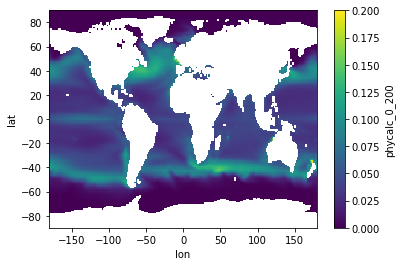

In [13]:
ds_hist.mean(dim=('time')).phycalc_0_200.plot(vmin=0, vmax=0.2)

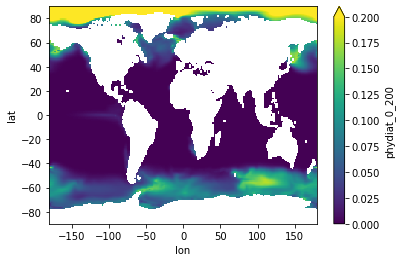

In [14]:
ds_hist.mean(dim=('time')).phydiat_0_200.plot(vmin=0, vmax=0.2)

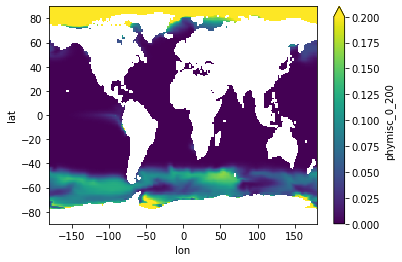

In [15]:
ds_hist.mean(dim=('time')).phymisc_0_200.plot(vmin=0, vmax=0.2)

## Step 1b. Compute total global carbon

In [16]:
area_path = '/work/m1c/GFDL_files/ocean_cobalt_omip_tracers_month_z_1x1deg.static.nc'
area_grid = xr.open_dataset(area_path)
# coordinates need to match with the previous files
area_grid.coords['lon'] = (area_grid.coords['lon'] + 180) % 360 - 180
area_grid = area_grid.sortby(area_grid.lon)
#area_grid = area_grid.sortby(area_grid.lat) 
#area_grid = area_grid.assign_coords(lat=(area_grid.lat * -1))

area_grid

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, bnds: 2)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: bnds
Data variables:
    areacello  (lat, lon) float32 ...
    deptho     (lat, lon) float32 ...
    geolat     (lat, lon) float32 ...
    geolon     (lat, lon) float32 ...
    hfgeou     (lat, lon) float32 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    sftof      (lat, lon) float32 ...
    wet        (lat, lon) float32 ...
Attributes:
    filename:                   ocean_cobalt_omip_tracers_month_z_1x1deg.stat...
    title:                      OMp5_IAF_BLING_baseline
    grid_type:                  regular
    grid_tile:                  N/A
    history:                    fregrid --standard_dimension --input_mosaic o...
    history_of_appended_files:  Thu Jan 31 02:22:00 2019: Appended file 18540...
    NCO:                        "4.6.4"
    code_version:               $Name: bronx-10_performance_z1l $
    external_variables:         areacello areacello

In [17]:
carbon_molar_mass = 12.011 # g/mol
# dictionary with total carbon
total_carbon_gC={}
total_carbon_gC['globalSum_gC']={}
total_carbon_gC['globalSum_gC']['phycalc'] = ((ds_hist.phycalc_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC['globalSum_gC']['phydiat'] = ((ds_hist.phydiat_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC['globalSum_gC']['phymisc'] = ((ds_hist.phymisc_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC['globalSum_gC']['zooc'] = ((ds_hist.zooc_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC

{'globalSum_gC': {'phycalc': 150454494769386.62,
  'phydiat': 68847064716729.19,
  'phymisc': 83286942336001.03,
  'zooc': 83593576800122.08}}

In [18]:
# transform the dictionary to a dataframe
biomass=pd.DataFrame.from_dict(total_carbon_gC)
biomass=biomass.reset_index()
biomass.columns.values[0]='name'
biomass

,name,globalSum_gC
0,phycalc,1.504545e+14
1,phydiat,6.884706e+13
2,phymisc,8.328694e+13
3,zooc,8.359358e+13


## Step3: complete table with size classes 

In [19]:
sizes=np.linspace(np.log10(2),np.log10(2.*1000.),num=1000,endpoint=False)
#10**(sizes)
#sizes

In [20]:
dd=np.diff(sizes)[0]
sizes_min=10**(sizes-dd/2)
sizes_max=10**(sizes+dd/2)
size_range=[str(np.round(10**s,3))+': '+'['+str(np.round(x,3))+','+str(np.round(y,3))+')' for s,x,y in zip(sizes,sizes_min,sizes_max)]
#size_range

In [21]:
sizedf=pd.DataFrame([10**sizes]).transpose()
sizedf.columns=['sizes']
sizedf['phyto']= None
sizedf['phytomisc']= None # withoutphytomisc, phymisc information dissapears (it is all masked by phycalc)
sizedf['zoo']= None
#sizedf.loc[sizedf.sizes < 10,'phyto']='smp'
sizedf.loc[(sizedf.sizes > 2) & (sizedf.sizes < 10),'phytomisc']='phymisc'
sizedf.loc[(sizedf.sizes > 10) & (sizedf.sizes < 100),'phyto']='phydiat' ##Playing with diatom size 
sizedf.loc[(sizedf.sizes > 2) & (sizedf.sizes < 75),'phyto']='phycalc'
sizedf.loc[(sizedf.sizes > 10) & (sizedf.sizes < 2000),'zoo']='zooc'
#sizedf.loc[(sizedf.sizes > 2000) & (sizedf.sizes < 20000),'zoo']='lgz'
##this step is necessary to remove the empty categories when we are not considering phymisc


#sizedf

In [22]:
# determine the degree of overlap between size bins. In COBALT (and perhaps other models) the degree of overlap might need to be determined following 
# Jessica's method

# the goal is to have repeated entries for a size class if it occurs across plantkon types:
sdfm = pd.melt(sizedf, id_vars='sizes',var_name='type',value_name='name')
sdfm = sdfm.dropna().reset_index(drop=True)
pd.set_option('display.max_rows',80)
#sdfm

In [23]:
# assign biovolume and amount of acrbon to each size bin
import math

#sdfm['biovolume_um3']=(4/3)*math.pi*(sdfm.sizes/2)**3

sdfm['biovolume_um3']=sdfm['sizes'].apply(lambda x: (4/3)*math.pi*(x/2)**3)

zoo_thres = (4/3)*math.pi*(200/2)**3 # biovolume that marks the difference in size between microzooplantkon and mesozooplankton



sdfm['mg_carbon']=0



#phymisc is all nanophytoplankton in GISS, Menden deuder and lessard (2000), 
tmp=sdfm.loc[(sdfm.name=='phymisc') & (sdfm.biovolume_um3 < 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='phymisc') &  (sdfm.biovolume_um3 < 3000),'mg_carbon']=10**(-0.583 + 0.860 * np.log10(tmp)) * 1e-9

tmp=sdfm.loc[(sdfm.name=='phymisc') & (sdfm.biovolume_um3 >= 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='phymisc')  & (sdfm.biovolume_um3 >= 3000),'mg_carbon']=10**(-0.665 + 0.939 * np.log10(tmp)) * 1e-9


#Villiot et al. (2021)
sdfm.loc[sdfm.name=='phycalc','mg_carbon']=0.3 * sdfm.loc[sdfm.name=='phycalc','biovolume_um3']**0.70 * 1e-9 


# diatoms, Menden-Deuer and Lessard 2000
# < 3000 um3 biovolume
tmp=sdfm.loc[(sdfm.name=='phydiat') & (sdfm.biovolume_um3 <= 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='phydiat') & (sdfm.biovolume_um3 <= 3000),'mg_carbon']=10**(-0.541 + 0.811 * np.log10(tmp)) * 1e-9
# > 3000 um3 biovolume OJO under current size classes, all phydiat will fit here. This might be a big source of biomass overestimation
tmp=sdfm.loc[(sdfm.name=='phydiat') & (sdfm.biovolume_um3 > 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='phydiat') & (sdfm.biovolume_um3 > 3000),'mg_carbon']=10**(-0.933 + 0.881 * np.log10(tmp)) * 1e-9


# zooc, Menden-Deuer and Lessard 2000 for  small microzooplankton
tmp=sdfm.loc[(sdfm.name=='zooc') & (sdfm.biovolume_um3 <= zoo_thres) & (sdfm.biovolume_um3 < 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='zooc') & (sdfm.biovolume_um3 <= zoo_thres) & (sdfm.biovolume_um3 < 3000),'mg_carbon']=10**(-0.583 + 0.860 * np.log10(tmp)) * 1e-9


# zooc, Menden-Deuer and Lessard 2000 for large  microzooplankton
tmp=sdfm.loc[(sdfm.name=='zooc') & (sdfm.biovolume_um3 <= zoo_thres) & (sdfm.biovolume_um3 >= 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='zooc') & (sdfm.biovolume_um3 <= zoo_thres) & (sdfm.biovolume_um3 >= 3000),'mg_carbon']=10**(-0.665 + 0.939 * np.log10(tmp)) * 1e-9



# mesozooplankton part of zooc, Pitt et al. 2013 will be deprecated, we will use Kiorboe (2013)/Maas et al. (2021) combo
tmp=sdfm.loc[(sdfm.name=='zooc') & (sdfm.biovolume_um3 > zoo_thres),'biovolume_um3'] # OJO notice here that I am using sizes (ESD) instead of biovolume since Pitt used ESD
tmp = 0.055 * (tmp/1e9) # Maas et al. takes milimeters cubed (notice conversion) and returns dry mass in mg
tmp = 10**((np.log10(tmp)-(-0.67))/0.96) # Kiorboe et al. takes dry mass in mg to wet mass in mg
sdfm.loc[(sdfm.name=='zooc') & (sdfm.biovolume_um3 > zoo_thres),'mg_carbon'] = (10**((0.95*np.log10(tmp))-0.93))# Kiorboe et al. takes wet mass  and returns mass of carbon

len(sdfm)


1565

In [24]:
sdfm.loc[sdfm.name=='zmicro'].biovolume_um3.max()

nan

## define the linear regressions for the PFTs that can use more than one allomentric relations due to its size range. For GISS these are phymisc phydiat and zooc:

## first, phymisc

In [25]:
df_phymisc = sdfm.loc[sdfm.name=='phymisc'].reset_index()
df_phymisc['pg_carbon'] = df_phymisc['mg_carbon']*1e9
df_phymisc

,index,sizes,type,name,biovolume_um3,mg_carbon,pg_carbon
0,566,2.013863,phytomisc,phymisc,4.276501,9.114570e-10,0.911457
1,567,2.027823,phytomisc,phymisc,4.366049,9.278466e-10,0.927847
2,568,2.041879,phytomisc,phymisc,4.457472,9.445310e-10,0.944531
3,569,2.056033,phytomisc,phymisc,4.550809,9.615153e-10,0.961515
4,570,2.070284,phytomisc,phymisc,4.646101,9.788051e-10,0.978805
...,...,...,...,...,...,...,...
227,793,9.661176,phytomisc,phymisc,472.159366,5.208542e-08,52.085424
228,794,9.728144,phytomisc,phymisc,482.046140,5.302201e-08,53.022012
229,795,9.795576,phytomisc,phymisc,492.139937,5.397544e-08,53.975442
230,796,9.863476,phytomisc,phymisc,502.445093,5.494602e-08,54.946015


In [26]:
slope_phymisc, intercept_phymisc, r_value_phymisc, p_value_phymisc, std_err_phymisc = linregress(x=np.log10(df_phymisc.biovolume_um3),y=np.log10(df_phymisc.pg_carbon))

In [27]:
slope_phymisc

0.8600000000000002

In [28]:
intercept_phymisc

-0.583

## now, phydiat

In [29]:
df_phydiat = sdfm.loc[sdfm.name=='phydiat'].reset_index()
df_phydiat['pg_carbon'] = df_phydiat['mg_carbon']*1e9
df_phydiat

,index,sizes,type,name,biovolume_um3,mg_carbon,pg_carbon
0,524,75.167481,phyto,phydiat,222376.355987,0.000006,5994.943091
1,525,75.688517,phyto,phydiat,227032.802070,0.000006,6105.399191
2,526,76.213165,phyto,phydiat,231786.751730,0.000006,6217.890431
3,527,76.741449,phyto,phydiat,236640.246642,0.000006,6332.454308
4,528,77.273395,phyto,phydiat,241595.371231,0.000006,6449.129011
5,529,77.809029,phyto,phydiat,246654.253570,0.000007,6567.953431
6,530,78.348375,phyto,phydiat,251819.066294,0.000007,6688.967176
7,531,78.891460,phyto,phydiat,257092.027530,0.000007,6812.210585
8,532,79.438310,phyto,phydiat,262475.401852,0.000007,6937.724739
9,533,79.988950,phyto,phydiat,267971.501253,0.000007,7065.551476


In [30]:
slope_phydiat, intercept_phydiat, r_value_phydiat, p_value_phydiat, std_err_phydiat = linregress(x=np.log10(df_phydiat.biovolume_um3),y=np.log10(df_phydiat.pg_carbon))

In [31]:
slope_phydiat

0.8810000000000002

In [32]:
intercept_phydiat

-0.9330000000000007

## now zooc

In [33]:
df_zooc = sdfm.loc[sdfm.name=='zooc'].reset_index()
df_zooc['pg_carbon'] = df_zooc['mg_carbon']*1e9
df_zooc

,index,sizes,type,name,biovolume_um3,mg_carbon,pg_carbon
0,798,10.000691,zoo,zooc,5.237073e+02,5.693983e-08,5.693983e+01
1,799,10.070012,zoo,zooc,5.346734e+02,5.796371e-08,5.796371e+01
2,800,10.139814,zoo,zooc,5.458692e+02,5.900600e-08,5.900600e+01
3,801,10.210100,zoo,zooc,5.572994e+02,6.006704e-08,6.006704e+01
4,802,10.280873,zoo,zooc,5.689690e+02,6.114715e-08,6.114715e+01
...,...,...,...,...,...,...,...
762,1560,1932.101758,zoo,zooc,3.776492e+09,1.141779e-01,1.141779e+08
763,1561,1945.494448,zoo,zooc,3.855570e+09,1.165436e-01,1.165436e+08
764,1562,1958.979971,zoo,zooc,3.936304e+09,1.189582e-01,1.189582e+08
765,1563,1972.558971,zoo,zooc,4.018728e+09,1.214229e-01,1.214229e+08


In [34]:
slope_zooc, intercept_zooc, r_value_zooc, p_value_zooc, std_err_zooc = linregress(x=np.log10(df_zooc.biovolume_um3),y=np.log10(df_zooc.pg_carbon))

In [35]:
slope_zooc

0.8834989490433213

In [36]:
intercept_zooc

-0.4901773772265505

## Now use these linear regressions to inform the functions from carbon to biovolume:

In [37]:
def g_carbon_to_biovol(x, v): # allometric relations based on Menden-Deuder and Lessard() for phymisc, zmicro and phydiat,  and Pitt et al. for zmeso. takes grams, converts to picograms
    if v =='phymisc':
        x_biovol = 10**((np.log10(x*1e12)-(intercept_phymisc))/slope_phymisc)
        
    elif v =='phycalc':
        x_biovol = 10**((np.log10(x*1e12)-(-0.3))/0.70)#10**((np.log10(x*1e12)-(-0.3))/0.70) # from Villion et al. after log transformation: log(pg cell^-1) = 0.7*log(um3) - 0.3k
        
    elif v == 'phydiat':
        x_biovol = 10**((np.log10(x*1e12)-(intercept_phydiat))/slope_phydiat) # onnly one regressionn for diatoms since all diatoms here are >3000 um3


    elif v == 'zooc':
        x_biovol = 10**((np.log10(x*1e12)-(intercept_zooc))/slope_zooc) # onnly one regressionn for diatoms since all diatoms here are >3000 um3
        
    return x_biovol

In [38]:
global_um3_list = []
for n, v in enumerate(biomass.name.unique()):
    global_um3_list.append(g_carbon_to_biovol(biomass.globalSum_gC[n], v))
biomass['globalSum_um3'] = global_um3_list

In [39]:
biomass

,name,globalSum_gC,globalSum_um3
0,phycalc,1.504545e+14,6.681355e+37
1,phydiat,6.884706e+13,2.437419e+30
2,phymisc,8.328694e+13,6.578285e+30
3,zooc,8.359358e+13,7.855410e+29


## Step 3. pull together and merge the overlapping size bins. The total global biovolume is split by the size bins


In [40]:

sdfm['globalSum_um3_split']=0
for s in sdfm.name.unique():
    n=len(sdfm.loc[sdfm.name==s].index)
    print(s, n)
    sdfm.loc[sdfm.name==s,'globalSum_um3_split'] = np.tile(biomass.loc[biomass.name==s,'globalSum_um3']/n,n)
sdfm

phycalc 524
phydiat 42
phymisc 232
zooc 767


,sizes,type,name,biovolume_um3,mg_carbon,globalSum_um3_split
0,2.013863,phyto,phycalc,4.276501e+00,8.296278e-10,1.275068e+35
1,2.027823,phyto,phycalc,4.366049e+00,8.417503e-10,1.275068e+35
2,2.041879,phyto,phycalc,4.457472e+00,8.540500e-10,1.275068e+35
3,2.056033,phyto,phycalc,4.550809e+00,8.665294e-10,1.275068e+35
4,2.070284,phyto,phycalc,4.646101e+00,8.791911e-10,1.275068e+35
...,...,...,...,...,...,...
1560,1932.101758,zoo,zooc,3.776492e+09,1.141779e-01,1.024173e+27
1561,1945.494448,zoo,zooc,3.855570e+09,1.165436e-01,1.024173e+27
1562,1958.979971,zoo,zooc,3.936304e+09,1.189582e-01,1.024173e+27
1563,1972.558971,zoo,zooc,4.018728e+09,1.214229e-01,1.024173e+27


In [41]:
sdfm = sdfm.sort_values(by='biovolume_um3', ascending=True)

In [42]:
small_increment_biovol = (sdfm['biovolume_um3'][1]-sdfm['biovolume_um3'][0])/2 # small increment is used to define the maximum and minimum of the size range

In [43]:
# create log-spaced bins for mg_carbon
bins_biovol = np.logspace(np.log10(sdfm['biovolume_um3'].min()-small_increment_biovol), np.log10(sdfm['biovolume_um3'].max()+small_increment_biovol), 51)


# use pandas.cut to bin the data into log-spaced bins
sdfm['biovolume_um3_bin'] = pd.cut(sdfm['biovolume_um3'], bins=bins_biovol, include_lowest=False)
sdfm['bin_centers_biovol'] = sdfm['biovolume_um3_bin'].apply(lambda x:x.mid).astype(float) # this gets the mid point 
sdfm['bin_range_biovol'] = sdfm['biovolume_um3_bin'].apply(lambda x:x.length).astype(float)

#len(sdfm)

In [44]:
sdfm.head()

,sizes,type,name,biovolume_um3,mg_carbon,globalSum_um3_split,biovolume_um3_bin,bin_centers_biovol,bin_range_biovol
0,2.013863,phyto,phycalc,4.276501,8.296278e-10,1.275068e+35,"(4.232, 6.401]",5.3165,2.169
566,2.013863,phytomisc,phymisc,4.276501,9.114570e-10,2.835468e+28,"(4.232, 6.401]",5.3165,2.169
567,2.027823,phytomisc,phymisc,4.366049,9.278466e-10,2.835468e+28,"(4.232, 6.401]",5.3165,2.169
1,2.027823,phyto,phycalc,4.366049,8.417503e-10,1.275068e+35,"(4.232, 6.401]",5.3165,2.169
2,2.041879,phyto,phycalc,4.457472,8.540500e-10,1.275068e+35,"(4.232, 6.401]",5.3165,2.169


In [45]:
len(sdfm)

1565

In [46]:
df_grouped_biovol = sdfm.groupby([ 'name', 'biovolume_um3_bin','bin_centers_biovol', 'bin_range_biovol']).agg(biovolume_um3=('biovolume_um3','mean'), globalSum_um3=('globalSum_um3_split','sum'),
                                                                                                             sizes=('sizes','mean'))


df_grouped_biovol = df_grouped_biovol.dropna().sort_values(by = ['sizes']).reset_index()
df_grouped_biovol['NB'] = df_grouped_biovol.globalSum_um3/df_grouped_biovol.bin_range_biovol
df_grouped_biovol.sizes = df_grouped_biovol.sizes.round(1)
df_grouped_biovol



,name,biovolume_um3_bin,bin_centers_biovol,bin_range_biovol,biovolume_um3,globalSum_um3,sizes,NB
0,phycalc,"(4.232, 6.401]",5.316500e+00,2.169000e+00,5.244268e+00,2.550135e+36,2.2,1.175719e+36
1,phymisc,"(4.232, 6.401]",5.316500e+00,2.169000e+00,5.244268e+00,5.670935e+29,2.2,2.614539e+29
2,phymisc,"(6.401, 9.682]",8.041500e+00,3.281000e+00,7.937521e+00,5.670935e+29,2.5,1.728417e+29
3,phycalc,"(6.401, 9.682]",8.041500e+00,3.281000e+00,7.937521e+00,2.550135e+36,2.5,7.772433e+35
4,phycalc,"(9.682, 14.646]",1.216400e+01,4.964000e+00,1.201392e+01,2.550135e+36,2.8,5.137259e+35
...,...,...,...,...,...,...,...,...
76,zooc,"(518121384.288, 783723619.633]",6.509225e+08,2.656022e+08,6.466732e+08,2.048347e+28,1071.2,7.712085e+19
77,zooc,"(783723619.633, 1185480334.525]",9.846020e+08,4.017567e+08,9.787796e+08,2.048347e+28,1229.9,5.098476e+19
78,zooc,"(1185480334.525, 1793187787.556]",1.489334e+09,6.077075e+08,1.481443e+09,2.048347e+28,1412.1,3.370613e+19
79,zooc,"(1793187787.556, 2712421579.502]",2.252805e+09,9.192338e+08,2.242254e+09,2.048347e+28,1621.3,2.228320e+19


In [47]:
bin_info = pd.DataFrame({
    'biovolume_um3_bin': np.sort(sdfm['biovolume_um3_bin'].unique()),
    'bin_centers_biovol': np.sort(sdfm['bin_centers_biovol'].unique())})

In [48]:
bin_info

,biovolume_um3_bin,bin_centers_biovol
0,"(4.232, 6.401]",5.316500e+00
1,"(6.401, 9.682]",8.041500e+00
2,"(9.682, 14.646]",1.216400e+01
3,"(14.646, 22.154]",1.840000e+01
4,"(22.154, 33.51]",2.783200e+01
5,"(33.51, 50.688]",4.209900e+01
6,"(50.688, 76.672]",6.368000e+01
7,"(76.672, 115.976]",9.632400e+01
8,"(115.976, 175.429]",1.457025e+02
9,"(175.429, 265.358]",2.203935e+02


## Calculate  total biomass and normalized biomass per size class

In [49]:
lat = ds_hist.lat
lon = ds_hist.lon
time = ds_hist.time
biovol_um3 = bin_info['bin_centers_biovol']
data = np.zeros((len(biovol_um3), len(time), len(lat), len(lon)))
biovolume_all = xr.DataArray(data, coords={'biovol_um3':biovol_um3, 'time':time, 'lat':lat, 'lon':lon},
            dims = ['biovol_um3', 'time', 'lat', 'lon'])


lat_NB = ds_hist.lat
lon_NB = ds_hist.lon
time_NB = ds_hist.time
biovol_um3_NB = bin_info['bin_centers_biovol']
data_NB = np.zeros((len(biovol_um3_NB), len(time_NB), len(lat_NB), len(lon_NB)))
biovolume_all_NB = xr.DataArray(data_NB, coords={'biovol_um3':biovol_um3_NB, 'time':time_NB, 'lat':lat_NB, 'lon':lon_NB},
            dims = ['biovol_um3', 'time', 'lat', 'lon'])

#time = ds.time
#data = np.zeros((len(time), len(mmolC), len(z_t_150m), len(nlat), len(nlon)))
#biomass_all = xr.DataArray(data, coords={'time':time, 'mass_mmolC':mmolC, 'z_t_150m':z_t_150m, 'nlat':nlat, 'nlon':nlon},
#            dims = ['time', 'mass_mmolC', 'z_t_150m', 'nlat', 'nlon'])




biovolume_all.shape

(50, 360, 180, 360)

In [50]:
biovolume_all_NB.shape

(50, 360, 180, 360)

In [51]:
def size_spectra(data_array,dataset, NB=False):
    for v in df_grouped_biovol['name'].unique():
        print(v)
        cobaltvar = v +'_0_200' # REMEMBER: it has to be with the integrated data variables, to remove depth dimensions
        x = dataset[cobaltvar]#.mean(dim='time') # average by time
        x = x.values * carbon_molar_mass # to g C
        x = g_carbon_to_biovol(x, v)

    
        # split up 
        n_split = len(df_grouped_biovol.loc[df_grouped_biovol.name==v].index)

        um_biovolume = df_grouped_biovol.loc[df_grouped_biovol.name==v,'bin_range_biovol'].values
        x_split = x / n_split

    
        x_rep = np.repeat(x_split[np.newaxis,...], n_split, axis=0)
    
        if NB==True:
            x_rep = x_rep / (um_biovolume[:,None,None,None]) # normalized biomass = integrated biomass / size-class

        # units are : um3 / m^2 / um3 ind-1

        print(np.nanmax(x_rep))
        # extract the indices corresponding to the bins where the plankton groups fall
        pft_bins=pd.unique(df_grouped_biovol.where(df_grouped_biovol.name==v).dropna().bin_centers_biovol)
        subset = bin_info[bin_info['bin_centers_biovol'].isin(pft_bins)]
        index_dims = subset.index.values
    
        # check lengths are the same
        if (n_split != len(index_dims)):
            print("Error: Dimension lengths are not the same")
            break
        #normalized biovolume
        biovolume_vals = data_array[index_dims,:,:,:].values
        biovolume_vals = biovolume_vals + x_rep
        # put into matrix
        data_array.values[index_dims,:,:,:] = biovolume_vals
    return(data_array)

In [52]:
biovolume_all = size_spectra(biovolume_all, ds_hist, NB=False)

phycalc
3.8230460621803366e+17
phymisc
1523774221959949.8
zooc
22850670053637.383
phydiat
2111445173343897.8


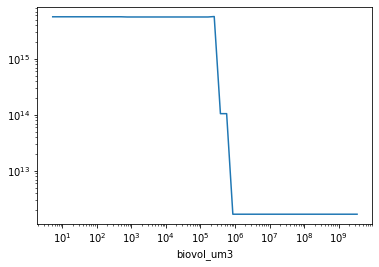

In [53]:
biovolume_all.mean(dim=('lat', 'lon', 'time')).plot()
plt.xscale('log')
plt.yscale('log')

## Get the total biovolume for only the size range included in PSSdb UVP+Zooscan

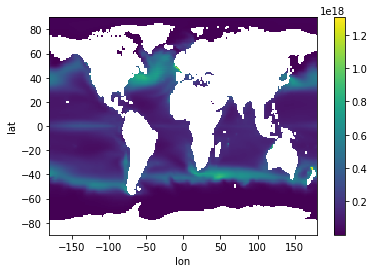

In [54]:
biovol_mask = ~np.isnan(biovolume_all.mean(dim=('biovol_um3')))
biovolume_all_subset= biovolume_all.where((biovolume_all['biovol_um3']>826400.0) & (biovolume_all['biovol_um3']<49100000000000.0)).sum(dim=['biovol_um3'])
biovolume_all= biovolume_all.sum(dim=['biovol_um3'])
biovolume_all = biovolume_all.where(biovol_mask)
biovolume_all_subset = biovolume_all_subset.where(biovol_mask)
biovolume_all.mean(dim=('time')).plot()



In [55]:
biovolume_all_NB = size_spectra(biovolume_all_NB, ds_hist, NB=True)

phycalc
1.7625846298664534e+17
phymisc
702523845993522.4
zooc
111054427484.49599
phydiat
20665457876.555786


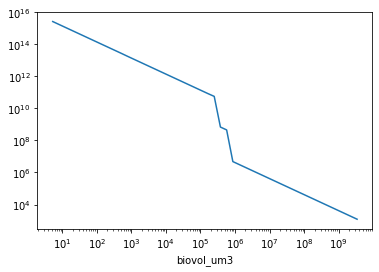

In [56]:
biovolume_all_NB.mean(dim=('lat', 'lon', 'time')).plot()
plt.xscale('log')
plt.yscale('log')

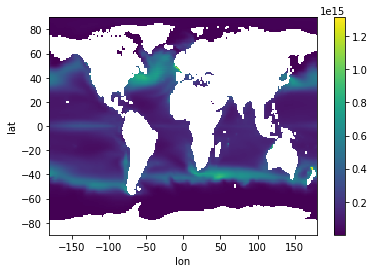

In [57]:
biovolume_all_NB.mean(dim=('time', 'biovol_um3')).plot()

In [58]:
# removing data from mediterranean and black sea
#biovolume_all.loc[dict(lat=biovolume_all.coords['lat'][(biovolume_all.coords['lat'] >= 30.5) & (biovolume_all.coords['lat'] <= 47.5)],
                                        #lon=biovolume_all.coords['lon'][(biovolume_all.coords['lon'] >= -5.5) & (biovolume_all.coords['lon'] <= 55.5)])]=float('nan') #

In [59]:
def calculate_size_spectra_slopes(data):
    data.values=np.log10(data.values)
    data = data.assign_coords(biovol_um3=np.log10(data.biovol_um3))
    cov_x = (data.biovol_um3.values - data.biovol_um3.mean().values)[:,None,None,None]
    cov_y = (data.values - data.mean(dim='biovol_um3').values[None,:,:,:])
    cov_xy = cov_x * cov_y
    covariance = np.nansum(cov_xy,axis=0)

    #variance = (data.mass_mgC.values.var() * (len(data.mass_mgC.values) - 1.))
    variance = np.nansum(cov_x**2, axis=0)

    betas = covariance / variance
    intercept_log = data.mean(dim='biovol_um3').values - (betas * data.biovol_um3.mean().values)
    intercept = 10**(data.mean(dim='biovol_um3').values - (betas * data.biovol_um3.mean().values))
    #print(betas.shape)
    #print(intercept.shape)
    #print(data.mass_mgC.values[:, None,None].shape)
    Y_pred = betas*(data.biovol_um3.values[:, None,None,None])+intercept_log
    ss_res = np.nansum((data.values - Y_pred)**2, axis = 0)
    ss_tot = np.nansum((cov_y)**2, axis = 0)
    R2 = 1-(ss_res/ss_tot)
    RMSE = (ss_res/data.biovol_um3.values.shape[0])**0.5
    #print(Y_pred.shape)
    #ss_tot = (data.values - data.mean(dim='mass_mgC').values[None,:,:])**2
    #ss_res = (data.values-Y_pred)
    #R2 = 1 - (ss_res / ss_tot)
    
    
    
    #betas = -betas # convention
    betas[betas == 0] = np.nan
    intercept[intercept ==0] = np.nan
    R2[R2 ==0] = np.nan
    RMSE[RMSE ==0] = np.nan
    
    return betas, intercept, R2, RMSE

In [60]:
betas_hist, intercept_hist, R2_hist, RMSE_hist = calculate_size_spectra_slopes(biovolume_all_NB)
betas_hist.shape

(360, 180, 360)

In [61]:
np.nanmean(betas_hist)

-1.6133266513772955

In [62]:
np.nanmax(betas_hist)

-0.662547931269245

In [63]:
np.nanmin(betas_hist)

-3.454391966056221

In [64]:
biovolume_all_NB.values=10**(biovolume_all_NB.values)

In [65]:
#phymisc=g_carbon_to_biovol(((ds_hist.phymisc_0_200.values)*carbon_molar_mass), 'phymisc')
#phycalc=g_carbon_to_biovol(((ds_hist.phycalc_0_200.values)*carbon_molar_mass), 'phycalc')
#phydiat=g_carbon_to_biovol(((ds_hist.phydiat_0_200.values)*carbon_molar_mass), 'phydiat')
#zooc=g_carbon_to_biovol(((ds_hist.zooc_0_200.values)*carbon_molar_mass), 'zooc')




## Get the slopes for each biome

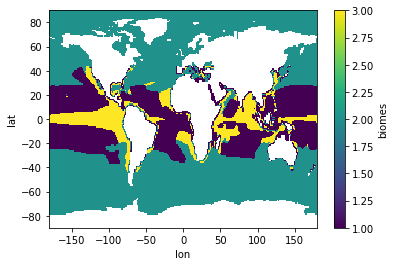

In [66]:
# load the biome mask
biome_mask = '/work/jyl/proj/CMIP6_models/ESM_Biomes/GISS_hist_biomes_x1.nc'
biomes_hist = xr.open_dataset(biome_mask)
biomes_mask = ~np.isnan(biomes_hist.biomes)
biomes_hist['biomes'] = biomes_hist['biomes'].where((biomes_hist['lat'] < 44.5) & (biomes_hist['lat'] > -44.5), 2)
biomes_hist = biomes_hist.where(biomes_mask)
#biomes_hist = biomes_hist.assign_coords(lat=(biomes_hist.lat * -1))
biomes_hist.biomes.plot()

In [67]:

# add slopes to the biomes dataset
biomes_hist['chl'] = (('time', 'lat', 'lon'), chl_hist.schl.values)
biomes_hist['chl'].attrs = {"units": 'kg m-3', 'Description': 'Surface Mass Concentration of Total Phytoplankton expressed as Chlorophyll in Sea Water'}

biomes_hist['NB'] = biovolume_all_NB
biomes_hist['NB'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'normalized biovolume for each size class'}

#biomes_hist['total_biovolume_hist_full'] = biovolume_all
biomes_hist['total_biovolume_hist'] = biovolume_all_subset#(('time', 'lat', 'lon'),biovolume_all.values)
biomes_hist['total_biovolume_hist'].attrs = {"units": 'um^3 ', 'Description': 'total biovolume from the size range of 116-2000 micrometers'}

biomes_hist['betas_hist'] = (('time', 'lat', 'lon'), betas_hist)
biomes_hist['betas_hist'].attrs = {"units": 'm^-2 m^-3', 'Description': 'Normalized biovolume size spectra slope'}

biomes_hist['intercept_hist'] = (('time', 'lat', 'lon'), intercept_hist)
biomes_hist['intercept_hist'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'Normalized biovolume size spectra intercept'}

biomes_hist['R2_hist'] = (('time', 'lat', 'lon'), R2_hist)
biomes_hist['R2_hist'].attrs = { 'Description': 'Normalized biovolume coefficient of determination'}

biomes_hist['RMSE_hist'] = (('time', 'lat', 'lon'), RMSE_hist)
biomes_hist['RMSE_hist'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'Normalized biovolume size spectra Root mean square error'}

#original_biomass_variables
biomes_hist['phycalc'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_hist.phycalc_0_200.values*carbon_molar_mass, 'phycalc'))
biomes_hist['phycalc'].attrs = {"units": 'um^3', 'Description': 'cocolithophore biovolume'}

biomes_hist['phymisc'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_hist.phymisc_0_200.values*carbon_molar_mass, 'phymisc'))
biomes_hist['phymisc'].attrs = {"units": 'um^3', 'Description': 'miscellaneous phytoplankton biovolume'}

biomes_hist['phydiat'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_hist.phydiat_0_200.values*carbon_molar_mass, 'phydiat'))
biomes_hist['phydiat'].attrs = {"units": 'um^3', 'Description': 'diatom biovolume'}

biomes_hist['zooc'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_hist.zooc_0_200.values*carbon_molar_mass, 'zooc'))
biomes_hist['zooc'].attrs = {"units": 'um^3', 'Description': 'zooplankton biovolume'}

biomes_hist['total_biovolume_full']=(('time', 'lat', 'lon'), biomes_hist.phycalc.values+biomes_hist.phymisc.values+biomes_hist.phydiat.values+biomes_hist.zooc.values)
biomes_hist['total_biovolume_full'].attrs = {"units": 'um^3', 'Description': 'all plankton biovolume'}
                                          
#percentage total
biomes_hist['phycalc_per'] = (('time', 'lat', 'lon'), (biomes_hist.phycalc.values/biomes_hist.total_biovolume_full.values)*100)
biomes_hist['phycalc_per'].attrs = {'Description': 'cocolithophore percentage of total biovolume'}

biomes_hist['phymisc_per'] = (('time', 'lat', 'lon'),(biomes_hist.phymisc.values/biomes_hist.total_biovolume_full.values)*100)
biomes_hist['phymisc_per'].attrs = {'Description': 'miscellaneous phytoplankton percentage of total biovolume'}
                                          
biomes_hist['phydiat_per'] = (('time', 'lat', 'lon'),(biomes_hist.phydiat.values/biomes_hist.total_biovolume_full.values)*100)
biomes_hist['phydiat_per'].attrs = {'Description': 'diatom percentage of total biovolume'}                                           
                                          
biomes_hist['zooc_per'] = (('time', 'lat', 'lon'),(biomes_hist.zooc.values/biomes_hist.total_biovolume_full.values)*100)
biomes_hist['zooc_per'].attrs = {'Description': 'zooplankton percentage of total biovolume'} 

#total biovolume
biomes_hist['phyc'] = (('time', 'lat', 'lon'), biomes_hist.phycalc.values+biomes_hist.phymisc.values+biomes_hist.phydiat.values)
biomes_hist['phyc'].attrs = {"units": 'um^3', 'Description': 'phytoplankton biovolume'}
                                          
#biomes_hist['total_biovolume_hist']= (('time', 'lat', 'lon'), phypico+phydiat+zooc)
biomes_hist

<xarray.Dataset>
Dimensions:               (time: 360, lat: 180, lon: 360, biovol_um3: 50)
Coordinates:
  * time                  (time) float64 1.985e+03 1.985e+03 ... 2.015e+03
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 5.316 8.041 ... 3.408e+09
Data variables: (12/18)
    biomes                (lat, lon) float64 nan nan nan nan ... 2.0 2.0 2.0 2.0
    chl                   (time, lat, lon) float64 2.832e-06 2.832e-06 ... nan
    NB                    (biovol_um3, time, lat, lon) float64 nan ... 3.756e+03
    total_biovolume_hist  (time, lat, lon) float64 nan nan ... 1.097e+14
    betas_hist            (time, lat, lon) float64 nan nan nan ... -1.216 -1.216
    intercept_hist        (time, lat, lon) float64 nan nan ... 6.36e+14 6.36e+14
    ...                    ...
    total_biovolume_full  (time, lat, lon) float64 nan nan ... 5.3e+15 5.3e+15
    phycalc_per           (time, lat, lon) float64 nan nan nan ... 1.245 1.245
    phymisc_per           (time, lat, lon) float64 nan nan nan ... 69.74 69.74
    phydiat_per           (time, lat, lon) float64 nan nan nan ... 25.17 25.17
    zooc_per              (time, lat, lon) float64 nan nan nan ... 3.843 3.843
    phyc                  (time, lat, lon) float64 nan nan ... 5.096e+15

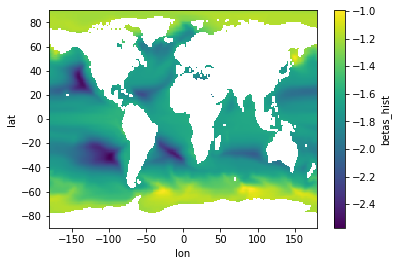

In [68]:
biomes_hist.mean(dim=('time')).betas_hist.plot()

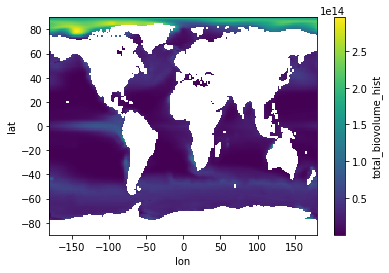

In [69]:
biomes_hist.mean(dim=('time')).total_biovolume_hist.plot()

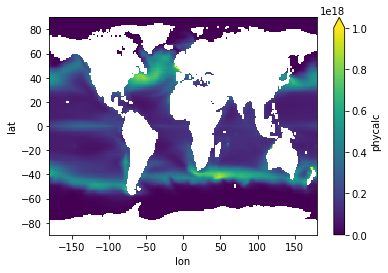

In [70]:
biomes_hist.mean(dim=('time')).phycalc.plot(vmin=0, vmax=1e18)

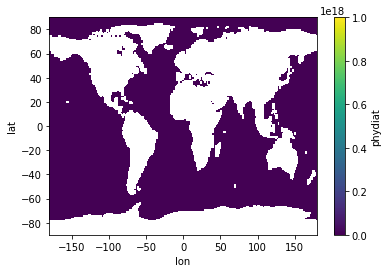

In [71]:
biomes_hist.mean(dim=('time')).phydiat.plot(vmin=0, vmax=1e18)

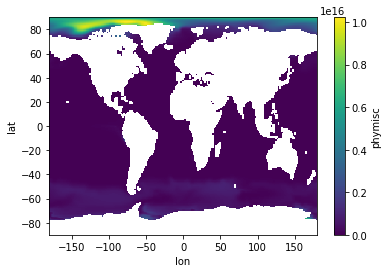

In [72]:
biomes_hist.mean(dim=('time')).phymisc.plot()

## Change time format from 365_day to day-month-year

In [73]:
biomes_hist=biomes_hist.assign_coords(year = np.trunc(biomes_hist.time).astype(int))#.astype(int)
biomes_hist=biomes_hist.assign_coords(day = ((biomes_hist.time - biomes_hist.year)*365).astype(int))
biomes_hist = biomes_hist.where(biomes_hist.day !=0, drop=True)

biomes_hist=biomes_hist.assign_coords(year = biomes_hist.year.astype(str))
biomes_hist=biomes_hist.assign_coords(day = np.char.zfill(biomes_hist.day.astype(str),3))



In [74]:
biomes_hist=biomes_hist.assign_coords(time = np.char.add(np.char.add(biomes_hist.year, '-'),biomes_hist.day))
#ds_hist=ds_hist.assign_coords(time = ds_hist.str.cat(ds_hist.year,ds_hist.day, sep = '-'))

In [75]:
biomes_hist= biomes_hist.drop_dims('day')
biomes_hist = biomes_hist.drop('year', dim=None)

In [76]:
#sorted(ds_hist.time.values)

In [77]:
from datetime import datetime as dt
biomes_hist=biomes_hist.assign_coords(time = [dt.strptime(x, '%Y-%j') for x in biomes_hist.time.values])

#ds_hist['time'].dt.strftime('%y%j')

In [78]:
biomes_hist = biomes_hist.sortby('time', ascending = True)

In [79]:
biomes_hist

<xarray.Dataset>
Dimensions:               (lat: 180, lon: 360, time: 360, biovol_um3: 50)
Coordinates:
  * time                  (time) datetime64[ns] 1985-01-16 ... 2014-12-16
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 5.316 8.041 ... 3.408e+09
Data variables: (12/18)
    biomes                (lat, lon, time) float64 nan nan nan ... 2.0 2.0 2.0
    chl                   (time, lat, lon) float64 2.832e-06 2.832e-06 ... nan
    NB                    (biovol_um3, time, lat, lon) float64 nan ... 3.756e+03
    total_biovolume_hist  (time, lat, lon) float64 nan nan ... 1.097e+14
    betas_hist            (time, lat, lon) float64 nan nan nan ... -1.216 -1.216
    intercept_hist        (time, lat, lon) float64 nan nan ... 6.36e+14 6.36e+14
    ...                    ...
    total_biovolume_full  (time, lat, lon) float64 nan nan ... 5.3e+15 5.3e+15
    phycalc_per           (time, lat, lon) float64 nan nan nan ... 1.245 1.245
    phymisc_per           (time, lat, lon) float64 nan nan nan ... 69.74 69.74
    phydiat_per           (time, lat, lon) float64 nan nan nan ... 25.17 25.17
    zooc_per              (time, lat, lon) float64 nan nan nan ... 3.843 3.843
    phyc                  (time, lat, lon) float64 nan nan ... 5.096e+15

In [80]:
biomes_hist.to_netcdf('/work/m1c/CMIP6_biome_PSS_data/biom_GISS_PSS_hist_biovolume.nc')

<h1><center> SAME PROCESS BUT FOR SSP5 8.5</center></h1>

## Pre step: combine the different files of the plankton into one netcdf file

In [81]:
# combine ssp5 data in one file and add variables by depth, and remove old datasets
ds_ssp585= xr.open_mfdataset(files_ssp585, combine = 'by_coords')

for i in [ 'phymisc', 'phycalc', 'phydiat', 'zooc']:
    ds_ssp585[i +'_0_200'] = ds_ssp585[i +'_100'] + ds_ssp585[i+'_200']
    ds_ssp585 = ds_ssp585.drop_vars([i+'_100', i+'_200'])
ds_ssp585=ds_ssp585.sel(time= slice(2070.0, 2100.0)) # some data later than 2100  had to be removed
ds_ssp585=ds_ssp585.sortby('lat', ascending=True)
ds_ssp585

<xarray.Dataset>
Dimensions:        (time: 360, lon: 360, lat: 180)
Coordinates:
  * time           (time) float64 2.07e+03 2.07e+03 2.07e+03 ... 2.1e+03 2.1e+03
  * lon            (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    phydiaz_100    (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phydiaz_200    (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phymisc_0_200  (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phycalc_0_200  (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phydiat_0_200  (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    zooc_0_200     (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>

In [82]:
#necessary step to make sure that cells with Nans are the same across the PFTs
ds_ssp585_mask = ~(np.isnan(ds_ssp585.phymisc_0_200) | np.isnan(ds_ssp585.phycalc_0_200) | np.isnan(ds_ssp585.phydiat_0_200) | np.isnan(ds_ssp585.zooc_0_200))
ds_ssp585 = ds_ssp585.where(ds_ssp585_mask)

In [83]:
carbon_molar_mass = 12.011 # g/mol
# dictionary with total carbon
total_carbon_gC_ssp585={}
total_carbon_gC_ssp585['globalSum_gC']={}
total_carbon_gC_ssp585['globalSum_gC']['phymisc'] = ((ds_ssp585.phymisc_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC_ssp585['globalSum_gC']['phycalc'] = ((ds_ssp585.phycalc_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC_ssp585['globalSum_gC']['phydiat'] = ((ds_ssp585.phydiat_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC_ssp585['globalSum_gC']['zooc'] = ((ds_ssp585.zooc_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC_ssp585

{'globalSum_gC': {'phymisc': 56093986860868.46,
  'phycalc': 148211282835116.6,
  'phydiat': 49454708309557.06,
  'zooc': 64947909807711.71}}

In [84]:
# transform the dictionary to a dataframe
biomass_ssp585=pd.DataFrame.from_dict(total_carbon_gC_ssp585)
biomass_ssp585=biomass_ssp585.reset_index()
biomass_ssp585.columns.values[0]='name'
biomass_ssp585

,name,globalSum_gC
0,phycalc,1.482113e+14
1,phydiat,4.945471e+13
2,phymisc,5.609399e+13
3,zooc,6.494791e+13


In [85]:
global_um3_list = []
for n, v in enumerate(biomass_ssp585.name.unique()):
    global_um3_list.append(g_carbon_to_biovol(biomass_ssp585.globalSum_gC[n], v))
biomass_ssp585['globalSum_um3'] = global_um3_list

In [86]:
biomass_ssp585

,name,globalSum_gC,globalSum_um3
0,phycalc,1.482113e+14,6.539502e+37
1,phydiat,4.945471e+13,1.674346e+30
2,phymisc,5.609399e+13,4.154391e+30
3,zooc,6.494791e+13,5.903478e+29


In [87]:
sizedf_ssp585=pd.DataFrame([10**sizes]).transpose()
sizedf_ssp585.columns=['sizes']
sizedf_ssp585['phyto']= None
sizedf_ssp585['phytomisc']= None
sizedf_ssp585['zoo']= None
#sizedf.loc[sizedf.sizes < 10,'phyto']='smp'
sizedf_ssp585.loc[(sizedf_ssp585.sizes > 2) & (sizedf_ssp585.sizes < 10),'phytomisc']='phymisc'
sizedf_ssp585.loc[(sizedf_ssp585.sizes > 10) & (sizedf_ssp585.sizes < 100),'phyto']='phydiat' ##Playing with diatom size 
sizedf_ssp585.loc[(sizedf_ssp585.sizes > 2) & (sizedf_ssp585.sizes < 75),'phyto']='phycalc'
sizedf_ssp585.loc[(sizedf_ssp585.sizes > 10) & (sizedf_ssp585.sizes < 2000),'zoo']='zooc'
#sizedf.loc[(sizedf.sizes > 2000) & (sizedf.sizes < 20000),'zoo']='lgz'
##this step is necessary to remove the empty categories when we are not considering phymisc

#sizedf_ssp585

In [88]:
# determine the degree of overlap between size bins. In COBALT (and perhaps other models) the degree of overlap might need to be determined following 
# Jessica's method

# the goal is to have repeated entries for a size class if it occurs across plantkon types:
sdfm_ssp585 = pd.melt(sizedf_ssp585, id_vars='sizes',var_name='type',value_name='name')
sdfm_ssp585 = sdfm_ssp585.dropna().reset_index(drop=True)
#pd.set_option('display.max_rows',80)
sdfm_ssp585

,sizes,type,name
0,2.013863,phyto,phycalc
1,2.027823,phyto,phycalc
2,2.041879,phyto,phycalc
3,2.056033,phyto,phycalc
4,2.070284,phyto,phycalc
...,...,...,...
1560,1932.101758,zoo,zooc
1561,1945.494448,zoo,zooc
1562,1958.979971,zoo,zooc
1563,1972.558971,zoo,zooc


In [89]:
# assign biovolume and amount of acrbon to each size bin
import math

#sdfm['biovolume_um3']=(4/3)*math.pi*(sdfm.sizes/2)**3

sdfm_ssp585['biovolume_um3']=sdfm_ssp585['sizes'].apply(lambda x: (4/3)*math.pi*(x/2)**3)

zoo_thres = (4/3)*math.pi*(200/2)**3 # biovolume that marks the difference in size between microzooplantkon and mesozooplankton



sdfm_ssp585['mg_carbon']=0


#phymisc is all nanophytoplankton in GISS, Menden deuder and lessard (2000), 
tmp=sdfm_ssp585.loc[(sdfm_ssp585.name=='phymisc') & (sdfm_ssp585.biovolume_um3 < 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='phymisc') &  (sdfm_ssp585.biovolume_um3 < 3000),'mg_carbon']=10**(-0.583 + 0.860 * np.log10(tmp)) * 1e-9

tmp=sdfm_ssp585.loc[(sdfm_ssp585.name=='phymisc') & (sdfm_ssp585.biovolume_um3 >= 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='phymisc')  & (sdfm_ssp585.biovolume_um3 >= 3000),'mg_carbon']=10**(-0.665 + 0.939 * np.log10(tmp)) * 1e-9


#Villiot et al. (2021)
sdfm_ssp585.loc[sdfm_ssp585.name=='phycalc','mg_carbon']=0.3 * sdfm_ssp585.loc[sdfm_ssp585.name=='phycalc','biovolume_um3']**0.70 * 1e-9 


# diatoms, Menden-Deuer and Lessard 2000
# < 3000 um3 biovolume
tmp=sdfm_ssp585.loc[(sdfm_ssp585.name=='phydiat') & (sdfm_ssp585.biovolume_um3 <= 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='phydiat') & (sdfm_ssp585.biovolume_um3 <= 3000),'mg_carbon']=10**(-0.541 + 0.811 * np.log10(tmp)) * 1e-9
# > 3000 um3 biovolume OJO under current size classes, all phydiat will fit here. This might be a big source of biomass overestimation
tmp=sdfm_ssp585.loc[(sdfm_ssp585.name=='phydiat') & (sdfm_ssp585.biovolume_um3 > 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='phydiat') & (sdfm_ssp585.biovolume_um3 > 3000),'mg_carbon']=10**(-0.933 + 0.881 * np.log10(tmp)) * 1e-9


# zooc, Menden-Deuer and Lessard 2000 for  small microzooplankton
tmp=sdfm_ssp585.loc[(sdfm_ssp585.name=='zooc') & (sdfm_ssp585.biovolume_um3 <= zoo_thres) & (sdfm_ssp585.biovolume_um3 < 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='zooc') & (sdfm_ssp585.biovolume_um3 <= zoo_thres) & (sdfm_ssp585.biovolume_um3 < 3000),'mg_carbon']=10**(-0.583 + 0.860 * np.log10(tmp)) * 1e-9


# zooc, Menden-Deuer and Lessard 2000 for large  microzooplankton
tmp=sdfm_ssp585.loc[(sdfm_ssp585.name=='zooc') & (sdfm_ssp585.biovolume_um3 <= zoo_thres) & (sdfm_ssp585.biovolume_um3 >= 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='zooc') & (sdfm_ssp585.biovolume_um3 <= zoo_thres) & (sdfm_ssp585.biovolume_um3 >= 3000),'mg_carbon']=10**(-0.665 + 0.939 * np.log10(tmp)) * 1e-9



# mesozooplankton part of zooc, Pitt et al. 2013 will be deprecated, we will use Kiorboe (2013)/Maas et al. (2021) combo
tmp=sdfm_ssp585.loc[(sdfm_ssp585.name=='zooc') & (sdfm_ssp585.biovolume_um3 > zoo_thres),'biovolume_um3'] # OJO notice here that I am using sizes (ESD) instead of biovolume since Pitt used ESD
tmp = 0.055 * (tmp/1e9) # Maas et al. takes milimeters cubed (notice conversion) and returns dry mass in mg
tmp = 10**((np.log10(tmp)-(-0.67))/0.96) # Kiorboe et al. takes dry mass in mg to wet mass in mg
sdfm_ssp585.loc[(sdfm_ssp585.name=='zooc') & (sdfm_ssp585.biovolume_um3 > zoo_thres),'mg_carbon'] = (10**((0.95*np.log10(tmp))-0.93))# Kiorboe et al. takes wet mass  and returns mass of carbon

sdfm_ssp585

,sizes,type,name,biovolume_um3,mg_carbon
0,2.013863,phyto,phycalc,4.276501e+00,8.296278e-10
1,2.027823,phyto,phycalc,4.366049e+00,8.417503e-10
2,2.041879,phyto,phycalc,4.457472e+00,8.540500e-10
3,2.056033,phyto,phycalc,4.550809e+00,8.665294e-10
4,2.070284,phyto,phycalc,4.646101e+00,8.791911e-10
...,...,...,...,...,...
1560,1932.101758,zoo,zooc,3.776492e+09,1.141779e-01
1561,1945.494448,zoo,zooc,3.855570e+09,1.165436e-01
1562,1958.979971,zoo,zooc,3.936304e+09,1.189582e-01
1563,1972.558971,zoo,zooc,4.018728e+09,1.214229e-01


## Step 3. pull together and merge the overlapping size bins. The total global carbon is split by the size bins.. yes?

In [90]:

sdfm_ssp585['globalSum_um3_split']=0
for s in sdfm_ssp585.name.unique():
    n=len(sdfm_ssp585.loc[sdfm.name==s].index)
    print(s, n)
    sdfm_ssp585.loc[sdfm_ssp585.name==s,'globalSum_um3_split'] = np.tile(biomass_ssp585.loc[biomass_ssp585.name==s,'globalSum_um3']/n,n)
sdfm_ssp585

phycalc 524
phydiat 42
phymisc 232
zooc 767


,sizes,type,name,biovolume_um3,mg_carbon,globalSum_um3_split
0,2.013863,phyto,phycalc,4.276501e+00,8.296278e-10,1.247997e+35
1,2.027823,phyto,phycalc,4.366049e+00,8.417503e-10,1.247997e+35
2,2.041879,phyto,phycalc,4.457472e+00,8.540500e-10,1.247997e+35
3,2.056033,phyto,phycalc,4.550809e+00,8.665294e-10,1.247997e+35
4,2.070284,phyto,phycalc,4.646101e+00,8.791911e-10,1.247997e+35
...,...,...,...,...,...,...
1560,1932.101758,zoo,zooc,3.776492e+09,1.141779e-01,7.696842e+26
1561,1945.494448,zoo,zooc,3.855570e+09,1.165436e-01,7.696842e+26
1562,1958.979971,zoo,zooc,3.936304e+09,1.189582e-01,7.696842e+26
1563,1972.558971,zoo,zooc,4.018728e+09,1.214229e-01,7.696842e+26


In [91]:
sdfm_ssp585 = sdfm_ssp585.sort_values(by='biovolume_um3', ascending=True)


In [92]:
sdfm_ssp585

,sizes,type,name,biovolume_um3,mg_carbon,globalSum_um3_split
0,2.013863,phyto,phycalc,4.276501e+00,8.296278e-10,1.247997e+35
566,2.013863,phytomisc,phymisc,4.276501e+00,9.114570e-10,1.790686e+28
567,2.027823,phytomisc,phymisc,4.366049e+00,9.278466e-10,1.790686e+28
1,2.027823,phyto,phycalc,4.366049e+00,8.417503e-10,1.247997e+35
2,2.041879,phyto,phycalc,4.457472e+00,8.540500e-10,1.247997e+35
...,...,...,...,...,...,...
1560,1932.101758,zoo,zooc,3.776492e+09,1.141779e-01,7.696842e+26
1561,1945.494448,zoo,zooc,3.855570e+09,1.165436e-01,7.696842e+26
1562,1958.979971,zoo,zooc,3.936304e+09,1.189582e-01,7.696842e+26
1563,1972.558971,zoo,zooc,4.018728e+09,1.214229e-01,7.696842e+26


In [93]:
small_increment = (sdfm_ssp585['biovolume_um3'][1]-sdfm_ssp585['biovolume_um3'][0])/2 # small increment is used to define the maximum and minimum of the size rang

In [94]:
# create log-spaced bins for mg_carbon
bins = np.logspace(np.log10(sdfm_ssp585['biovolume_um3'].min()-small_increment), np.log10(sdfm_ssp585['biovolume_um3'].max()+small_increment), 51)

# use pandas.cut to bin the data into log-spaced bins
sdfm_ssp585['biovolume_um3_bin'] = pd.cut(sdfm_ssp585['biovolume_um3'], bins=bins, include_lowest=False)
sdfm_ssp585['bin_centers'] = sdfm_ssp585['biovolume_um3_bin'].apply(lambda x:x.mid).astype(float) # this gets the mid point 
sdfm_ssp585['bin_range'] = sdfm_ssp585['biovolume_um3_bin'].apply(lambda x:x.length).astype(float)

len(sdfm_ssp585)

1565

In [95]:
df_grouped_ssp585 = sdfm_ssp585.groupby(['biovolume_um3_bin','bin_centers','bin_range', 'name']).agg(biovolume_um3=('biovolume_um3','mean'),
                                                                      sizes=('sizes','mean'))
df_grouped_ssp585 = df_grouped_ssp585.dropna().reset_index()
len(df_grouped_ssp585)

81

In [96]:
df_grouped_ssp585

,biovolume_um3_bin,bin_centers,bin_range,name,biovolume_um3,sizes
0,"(4.232, 6.401]",5.316500e+00,2.169000e+00,phycalc,5.244268e+00,2.152160
1,"(4.232, 6.401]",5.316500e+00,2.169000e+00,phymisc,5.244268e+00,2.152160
2,"(6.401, 9.682]",8.041500e+00,3.281000e+00,phycalc,7.937521e+00,2.471010
3,"(6.401, 9.682]",8.041500e+00,3.281000e+00,phymisc,7.937521e+00,2.471010
4,"(9.682, 14.646]",1.216400e+01,4.964000e+00,phycalc,1.201392e+01,2.837099
...,...,...,...,...,...,...
76,"(518121384.288, 783723619.633]",6.509225e+08,2.656022e+08,zooc,6.466732e+08,1071.209622
77,"(783723619.633, 1185480334.525]",9.846020e+08,4.017567e+08,zooc,9.787796e+08,1229.913207
78,"(1185480334.525, 1793187787.556]",1.489334e+09,6.077075e+08,zooc,1.481443e+09,1412.129303
79,"(1793187787.556, 2712421579.502]",2.252805e+09,9.192338e+08,zooc,2.242254e+09,1621.341373


In [97]:
bin_info_ssp585 = pd.DataFrame({
    'biovolume_um3_bin': np.sort(sdfm_ssp585['biovolume_um3_bin'].unique()),
    'bin_centers': np.sort(sdfm_ssp585['bin_centers'].unique())})

## Calculate  total biomass and normalized biomass per size class

In [98]:
lat = ds_ssp585.lat
lon = ds_ssp585.lon
time = ds_ssp585.time
biovol_um3 = bin_info_ssp585.bin_centers
data_ssp585 = np.zeros((len(biovol_um3), len(time), len(lat), len(lon)))
biovolume_all_ssp585 = xr.DataArray(data_ssp585, coords={'biovol_um3':biovol_um3, 'time':time, 'lat':lat, 'lon':lon},
            dims = ['biovol_um3', 'time','lat', 'lon'])

lat_NB = ds_ssp585.lat
lon_NB = ds_ssp585.lon
time_NB = ds_ssp585.time
biovol_um3_NB = bin_info_ssp585.bin_centers
data_ssp585_NB = np.zeros((len(biovol_um3_NB), len(time_NB), len(lat_NB), len(lon_NB)))
biovolume_all_ssp585_NB = xr.DataArray(data_ssp585_NB, coords={'biovol_um3':biovol_um3_NB, 'time':time_NB, 'lat':lat_NB, 'lon':lon_NB},
            dims = ['biovol_um3', 'time','lat', 'lon'])

#time = ds.time
#data = np.zeros((len(time), len(mmolC), len(z_t_150m), len(nlat), len(nlon)))
#biomass_all = xr.DataArray(data, coords={'time':time, 'mass_mmolC':mmolC, 'z_t_150m':z_t_150m, 'nlat':nlat, 'nlon':nlon},
#            dims = ['time', 'mass_mmolC', 'z_t_150m', 'nlat', 'nlon'])


biovolume_all_ssp585.shape

(50, 360, 180, 360)

In [99]:
biovolume_all_ssp585_NB.shape

(50, 360, 180, 360)

In [100]:
biovolume_all_ssp585 = size_spectra(biovolume_all_ssp585, ds_ssp585, NB=False)

phycalc
4.044320828370325e+17
phymisc
1240376792789758.8
zooc
17539485610491.879
phydiat
1832352467626364.2


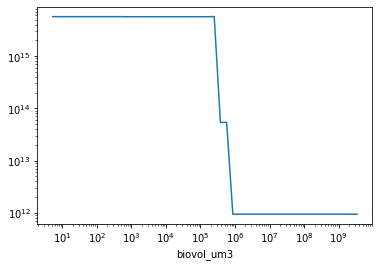

In [101]:
biovolume_all_ssp585.mean(dim=('lat', 'lon', 'time')).plot()
plt.xscale('log')
plt.yscale('log')

## Get the total biovolume for only the size range included in PSSdb UVP+Zooscan

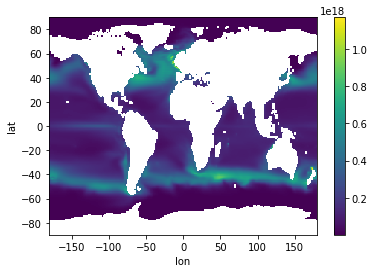

In [102]:
biovol_mask_ssp585 = ~np.isnan(biovolume_all_ssp585.mean(dim=('biovol_um3')))
biovolume_all_subset_ssp585= biovolume_all_ssp585.where((biovolume_all_ssp585['biovol_um3']>826400.0) & (biovolume_all_ssp585['biovol_um3']<49100000000000.0)).sum(dim=['biovol_um3'])
biovolume_all_ssp585= biovolume_all_ssp585.sum(dim=['biovol_um3'])
biovolume_all_ssp585 = biovolume_all_ssp585.where(biovol_mask_ssp585)
biovolume_all_subset_ssp585 = biovolume_all_subset_ssp585.where(biovol_mask_ssp585)
biovolume_all_ssp585.mean(dim=('time')).plot()

               

In [103]:
biovolume_all_ssp585_NB = size_spectra(biovolume_all_ssp585_NB, ds_ssp585, NB=True)

phycalc
1.8646015806225568e+17
phymisc
571865741258533.4
zooc
85242031339.71878
phydiat
17933879227.736053


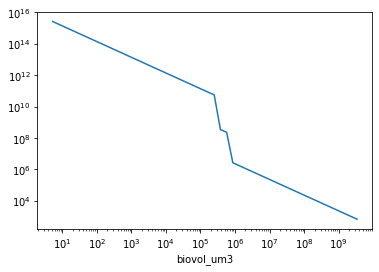

In [104]:
biovolume_all_ssp585_NB.mean(dim=('lat', 'lon', 'time')).plot()
plt.xscale('log')
plt.yscale('log')

In [105]:
# removing data from mediterranean and black sea
#biovolume_all_ssp585.loc[dict(lat=biovolume_all_ssp585.coords['lat'][(biovolume_all_ssp585.coords['lat'] >= 30.5) & (biovolume_all_ssp585.coords['lat'] <= 47.5)],
                                        #lon=biovolume_all_ssp585.coords['lon'][(biovolume_all_ssp585.coords['lon'] >= -5.5) & (biovolume_all_ssp585.coords['lon'] <= 55.5)])]=float('nan')#

In [106]:
betas_ssp5, intercept_ssp5, R2_ssp5, RMSE_ssp5 = calculate_size_spectra_slopes(biovolume_all_ssp585_NB)
betas_ssp5.shape

(360, 180, 360)

In [107]:
np.nanmean(betas_ssp5)

-1.6518464839069016

In [108]:
np.round(np.nanmin(intercept_hist), 3)

10718939594.262

In [109]:
np.round(np.nanmin(intercept_ssp5), 3)

251811230788.261

In [110]:
biovolume_all_ssp585_NB.values=10**(biovolume_all_ssp585_NB.values)

In [111]:
#phymisc=g_carbon_to_biovol(((ds_ssp585.phymisc_0_200.values)*carbon_molar_mass), 'phymisc')
#phycalc=g_carbon_to_biovol(((ds_ssp585.phycalc_0_200.values)*carbon_molar_mass), 'phycalc')
#phydiat=g_carbon_to_biovol(((ds_ssp585.phydiat_0_200.values)*carbon_molar_mass), 'phydiat')
#zooc=g_carbon_to_biovol(((ds_ssp585.zooc_0_200.values)*carbon_molar_mass), 'zooc')

## Get the slopes for each biome

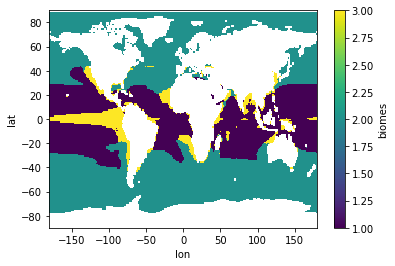

In [112]:
# load the biome mask
biome_mask = '/work/jyl/proj/CMIP6_models/ESM_Biomes/GISS_ssp585_biomes_x1.nc'
biomes_ssp5 = xr.open_dataset(biome_mask)
biomes_mask = ~np.isnan(biomes_ssp5.biomes)
biomes_ssp5['biomes'] = biomes_ssp5['biomes'].where((biomes_ssp5['lat'] > -44.5) & (biomes_ssp5['lat'] < 44.5), 2)
biomes_ssp5 = biomes_ssp5.where(biomes_mask)
#biomes_ssp5 = biomes_ssp5.assign_coords(lat=(biomes_ssp5.lat * -1))
biomes_ssp5.biomes.plot()

In [113]:

# add slopes to the biomes dataset
biomes_ssp5['chl'] = (('time', 'lat', 'lon'), chl_ssp5.schl.values)
biomes_ssp5['chl'].attrs = {"units": 'kg m-3', 'Description': 'Surface Mass Concentration of Total Phytoplankton expressed as Chlorophyll in Sea Water'}

biomes_ssp5['NB'] = biovolume_all_ssp585_NB
biomes_ssp5['NB'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'normalized biovolume for each size class'}

#biomes_ssp5['total_biovolume_ssp5_full'] = biovolume_all
biomes_ssp5['total_biovolume_ssp5'] = biovolume_all_subset_ssp585#(('time', 'lat', 'lon'),biovolume_all.values)
biomes_ssp5['total_biovolume_ssp5'].attrs = {"units": 'um^3 ', 'Description': 'total biovolume from the size range of 116-2000 micrometers'}

biomes_ssp5['betas_ssp5'] = (('time', 'lat', 'lon'), betas_ssp5)
biomes_ssp5['betas_ssp5'].attrs = {"units": 'm^-2 m^-3', 'Description': 'Normalized biovolume size spectra slope'}

biomes_ssp5['intercept_ssp5'] = (('time', 'lat', 'lon'), intercept_ssp5)
biomes_ssp5['intercept_ssp5'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'Normalized biovolume size spectra intercept'}

biomes_ssp5['R2_ssp5'] = (('time', 'lat', 'lon'), R2_ssp5)
biomes_ssp5['R2_ssp5'].attrs = { 'Description': 'Normalized biovolume coefficient of determination'}

biomes_ssp5['RMSE_ssp5'] = (('time', 'lat', 'lon'), RMSE_ssp5)
biomes_ssp5['RMSE_ssp5'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'Normalized biovolume size spectra Root mean square error'}

#original_biomass_variables
biomes_ssp5['phycalc'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_ssp585.phycalc_0_200.values*carbon_molar_mass, 'phycalc'))
biomes_ssp5['phycalc'].attrs = {"units": 'um^3', 'Description': 'cocolithophore biovolume'}

biomes_ssp5['phymisc'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_ssp585.phymisc_0_200.values*carbon_molar_mass, 'phymisc'))
biomes_ssp5['phymisc'].attrs = {"units": 'um^3', 'Description': 'miscellaneous phytoplankton biovolume'}

biomes_ssp5['phydiat'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_ssp585.phydiat_0_200.values*carbon_molar_mass, 'phydiat'))
biomes_ssp5['phydiat'].attrs = {"units": 'um^3', 'Description': 'diatom biovolume'}

biomes_ssp5['zooc'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_ssp585.zooc_0_200.values*carbon_molar_mass, 'zooc'))
biomes_ssp5['zooc'].attrs = {"units": 'um^3', 'Description': 'zooplankton biovolume'}

biomes_ssp5['total_biovolume_full']=(('time', 'lat', 'lon'), biomes_ssp5.phycalc.values+biomes_ssp5.phymisc.values+biomes_ssp5.phydiat.values+biomes_ssp5.zooc.values)
biomes_ssp5['total_biovolume_full'].attrs = {"units": 'um^3', 'Description': 'all plankton biovolume'}
                                          
#percentage total
biomes_ssp5['phycalc_per'] = (('time', 'lat', 'lon'), (biomes_ssp5.phycalc.values/biomes_ssp5.total_biovolume_full.values)*100)
biomes_ssp5['phycalc_per'].attrs = {'Description': 'cocolithophore percentage of total biovolume'}

biomes_ssp5['phymisc_per'] = (('time', 'lat', 'lon'),(biomes_ssp5.phymisc.values/biomes_ssp5.total_biovolume_full.values)*100)
biomes_ssp5['phymisc_per'].attrs = {'Description': 'miscellaneous phytoplankton percentage of total biovolume'}
                                          
biomes_ssp5['phydiat_per'] = (('time', 'lat', 'lon'),(biomes_ssp5.phydiat.values/biomes_ssp5.total_biovolume_full.values)*100)
biomes_ssp5['phydiat_per'].attrs = {'Description': 'diatom percentage of total biovolume'}                                           
                                          
biomes_ssp5['zooc_per'] = (('time', 'lat', 'lon'),(biomes_ssp5.zooc.values/biomes_ssp5.total_biovolume_full.values)*100)
biomes_ssp5['zooc_per'].attrs = {'Description': 'zooplankton percentage of total biovolume'} 

#total biovolume
biomes_ssp5['phyc'] = (('time', 'lat', 'lon'), biomes_ssp5.phycalc.values+biomes_ssp5.phymisc.values+biomes_ssp5.phydiat.values)
biomes_ssp5['phyc'].attrs = {"units": 'um^3', 'Description': 'phytoplankton biovolume'}
                                          
#biomes_ssp5['total_biovolume_ssp5']= (('time', 'lat', 'lon'), phypico+phydiat+zooc)
biomes_hist

<xarray.Dataset>
Dimensions:               (lat: 180, lon: 360, time: 360, biovol_um3: 50)
Coordinates:
  * time                  (time) datetime64[ns] 1985-01-16 ... 2014-12-16
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 5.316 8.041 ... 3.408e+09
Data variables: (12/18)
    biomes                (lat, lon, time) float64 nan nan nan ... 2.0 2.0 2.0
    chl                   (time, lat, lon) float64 2.832e-06 2.832e-06 ... nan
    NB                    (biovol_um3, time, lat, lon) float64 nan ... 3.756e+03
    total_biovolume_hist  (time, lat, lon) float64 nan nan ... 1.097e+14
    betas_hist            (time, lat, lon) float64 nan nan nan ... -1.216 -1.216
    intercept_hist        (time, lat, lon) float64 nan nan ... 6.36e+14 6.36e+14
    ...                    ...
    total_biovolume_full  (time, lat, lon) float64 nan nan ... 5.3e+15 5.3e+15
    phycalc_per           (time, lat, lon) float64 nan nan nan ... 1.245 1.245
    phymisc_per           (time, lat, lon) float64 nan nan nan ... 69.74 69.74
    phydiat_per           (time, lat, lon) float64 nan nan nan ... 25.17 25.17
    zooc_per              (time, lat, lon) float64 nan nan nan ... 3.843 3.843
    phyc                  (time, lat, lon) float64 nan nan ... 5.096e+15

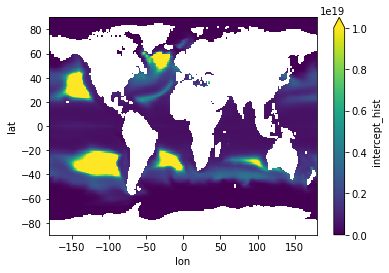

In [114]:
biomes_hist.mean(dim=('time')).intercept_hist.plot(vmin=1e7, vmax = 1e19)

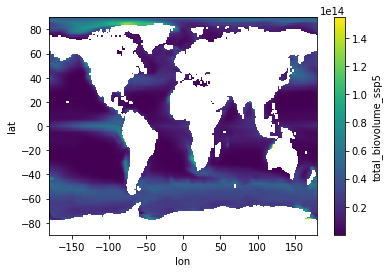

In [115]:
biomes_ssp5.mean(dim=('time')).total_biovolume_ssp5.plot()

## Change time format from 365_day to day-month-year

In [116]:
biomes_ssp5=biomes_ssp5.assign_coords(year = np.trunc(biomes_ssp5.time).astype(int))#.astype(int)
biomes_ssp5=biomes_ssp5.assign_coords(day = ((biomes_ssp5.time - biomes_ssp5.year)*365).astype(int))
biomes_ssp5 = biomes_ssp5.where(biomes_ssp5.day !=0, drop=True)

biomes_ssp5=biomes_ssp5.assign_coords(year = biomes_ssp5.year.astype(str))
biomes_ssp5=biomes_ssp5.assign_coords(day = np.char.zfill(biomes_ssp5.day.astype(str),3))



In [117]:
biomes_ssp5=biomes_ssp5.assign_coords(time = np.char.add(np.char.add(biomes_ssp5.year, '-'),biomes_ssp5.day))
#ds_hist=ds_hist.assign_coords(time = ds_hist.str.cat(ds_hist.year,ds_hist.day, sep = '-'))

In [118]:
biomes_ssp5= biomes_ssp5.drop_dims('day')
biomes_ssp5 = biomes_ssp5.drop('year', dim=None)

In [119]:
#sorted(ds_hist.time.values)

In [120]:
from datetime import datetime as dt
biomes_ssp5=biomes_ssp5.assign_coords(time = [dt.strptime(x, '%Y-%j') for x in biomes_ssp5.time.values])

#ds_hist['time'].dt.strftime('%y%j')

In [121]:
biomes_ssp5 = biomes_ssp5.sortby('time', ascending = True)

In [122]:
biomes_ssp5

<xarray.Dataset>
Dimensions:               (lat: 180, lon: 360, time: 360, biovol_um3: 50)
Coordinates:
  * time                  (time) datetime64[ns] 2070-01-16 ... 2099-12-16
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 5.316 8.041 ... 3.408e+09
Data variables: (12/18)
    biomes                (lat, lon, time) float64 nan nan nan ... nan nan nan
    chl                   (time, lat, lon) float64 1.684e-06 1.684e-06 ... nan
    NB                    (biovol_um3, time, lat, lon) float64 nan ... 1.668e+03
    total_biovolume_ssp5  (time, lat, lon) float64 nan nan ... 4.871e+13
    betas_ssp5            (time, lat, lon) float64 nan nan nan ... -1.232 -1.232
    intercept_ssp5        (time, lat, lon) float64 nan nan ... 3.932e+14
    ...                    ...
    total_biovolume_full  (time, lat, lon) float64 nan nan ... 2.558e+15
    phycalc_per           (time, lat, lon) float64 nan nan nan ... 2.932 2.932
    phymisc_per           (time, lat, lon) float64 nan nan nan ... 74.0 74.0
    phydiat_per           (time, lat, lon) float64 nan nan nan ... 19.53 19.53
    zooc_per              (time, lat, lon) float64 nan nan nan ... 3.536 3.536
    phyc                  (time, lat, lon) float64 nan nan ... 2.468e+15

In [123]:
biomes_ssp5.to_netcdf('/work/m1c/CMIP6_biome_PSS_data/biom_GISS_PSS_ssp5_biovolume.nc')

## include code to assess the size spectra

In [124]:
from wcmatch.pathlib import Path # Handling of path object

In [125]:
test_df = biomes_hist.mean(dim=['time']).to_dataframe()
test_df=test_df.dropna().reset_index()
test_df=test_df.drop_duplicates().reset_index(drop=True)
test_df['biomes'] = test_df['biomes'].astype(str)
test_df = test_df.replace({'biomes':{'1.0':'LC','2.0':'HCSS','3.0':'HCPS'}})

In [126]:
import math as m
test_df['source']='GISS'
test_df['ECD'] = ((test_df['biovol_um3']*6)/m.pi)**(1./3.)
test_df=test_df.astype(dict(zip(['biovol_um3', 'ECD'],[str]*2))).groupby(['source', 'biovol_um3', 'ECD']).apply(lambda x: pd.Series({'NB':np.nanmean(x.NB)})).reset_index()
test_df['biovol_um3']=test_df['biovol_um3'].astype(float)
test_df['ECD']=test_df['ECD'].astype(float)
test_df

,source,biovol_um3,ECD,NB
0,GISS,1.038042e+07,270.648418,2.212102e+05
1,GISS,1.094383e+05,59.345841,1.459941e+11
2,GISS,1.153783e+03,13.012930,1.384780e+13
3,GISS,1.216400e+01,2.853378,1.314683e+15
4,GISS,1.243379e+08,619.253300,1.846786e+04
5,GISS,1.310865e+06,135.785417,1.751710e+06
6,GISS,1.382014e+04,29.774051,1.156092e+12
7,GISS,1.457025e+02,6.528641,1.097689e+14
8,GISS,1.489334e+09,1416.873790,1.541800e+03
9,GISS,1.570169e+07,310.681909,1.462425e+05


In [127]:
bins_df = pd.read_csv('/work/m1c/CMIP6_biome_PSS_data/ecopart_size_bins.csv', sep = ',')
test_df.loc[:, 'sizeClasses']= pd.cut(x=test_df['ECD'], bins=bins_df['ESD_um'], include_lowest=True)# size classes defined by biovolume
test_df['ECD'] = test_df.sizeClasses.apply(lambda x: x.mid)
test_df=test_df.drop(columns=['sizeClasses']).reset_index()
test_df['NB']=(test_df['NB']/200)*0.001# conversion to liters

In [128]:
from plotnine import *
colors = dict(CESM= 'red',CMCC= 'cyan', CNRM= 'gray',GFDL= 'lawngreen',IPSL= 'gold', GISS= 'orange', UKESM= 'purple', PSSdb = 'blue')
breaks = [20, 200, 2000, 20000]#breaks = [1, 2, 20, 200]#
labels = [20, 200, 2000, 20000]#labels = [1, 2, 20, 200]#
theme_paper=theme(axis_ticks_direction="inout",
              panel_grid=element_blank(),
              axis_line = element_line(colour = "black"),
              panel_background=element_rect(fill='white'),
              panel_border=element_blank(),
              legend_title=element_text(family="serif", size=15),
              legend_position='none',#legend_position='top',
              legend_text=element_text(family="serif", size=15),
              axis_title=element_text(family="serif", size=15),
              axis_text_x=element_text(family="serif", size=15),
              axis_text_y=element_text(family="serif", size=15, rotation=90),
              plot_background=element_rect(fill='white'), strip_background=element_rect(fill='white'))

In [129]:
test_df['ECD']=test_df['ECD'].astype(float)

In [130]:
plot = (ggplot(data=test_df)+
        geom_line(test_df,aes(x='ECD', y='NB', color='source', group='source'),  size = 1) +
        geom_point(aes(x='ECD', y='NB',color='source', group='source'),size = 3,  shape = 'o')+
        #stat_summary(data=df_NB[df_NB.ECD.transform(lambda x: x.astype(str).isin(pd.Series(x.value_counts(normalize=True)[x.value_counts(normalize=True)>=np.quantile(x.value_counts(normalize=True),0.5)].index).astype(str)))],mapping=aes(x='ECD', y='NB'),geom='line', fun_y=np.nanmedian, size = 0.5, alpha=0.5)+
        #stat_summary(mapping=aes(x='ECD', y='NB'),geom='line', fun_y=np.nanmedian, size = 0.8)+
        labs(y=r'Normalized Biovolume ($\mu$m$^{3}$ m$^{-2}$ $\mu$m$^{-3}$)', x=r'Equivalent circular diameter ($\mu$m)')+
        scale_color_manual(values = colors)+
        scale_y_log10(breaks=[10**np.arange(-5,10,step=2, dtype=np.float)][0],labels=['10$^{%s}$'% int(n) for n in np.arange(-5,10,step=2)] , limits=(1e-5, 1e11))+
        #scale_y_log10(breaks=[10**np.arange(-5,-3,step=0.5, dtype=np.float)][0],labels=['10$^{%s}$'% int(n) for n in np.arange(-5,-3,step=0.5)] , limits=(1e-5, 1e-3))+
        scale_x_log10(breaks=breaks, labels=labels,limits=(0.5, 35000))+
        #scale_x_log10(breaks=[size  for size in np.sort( np.concatenate(np.arange(1, 10).reshape((9, 1)) * np.power(10, np.arange(1, 5, 1))))],labels= [size if (size / np.power(10, np.ceil(np.log10(size)))) == 1 else '' for size in np.sort( np.concatenate(np.arange(1, 10).reshape((9, 1)) * np.power(10, np.arange(1, 5, 1))))], limits=(1, 15000))+
        theme_paper).draw(show=False)
plot.set_size_inches(6,6)
plot.savefig(fname='{}/work/CMIP6_size_spectra_scripts/plots/NBSS_GISS_mean.pdf'.format(str(Path.home())), dpi=300)